# Draft

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime as dt

jtplot.style(figsize=(15, 9))

In [3]:
# tickers = ['GLD', 'GDX', 'AAPL', 'SPY']
# d_start = dt.datetime(2010, 1, 1)
# d_final = dt.datetime(2020, 12, 31)

<AxesSubplot:xlabel='Datetime'>

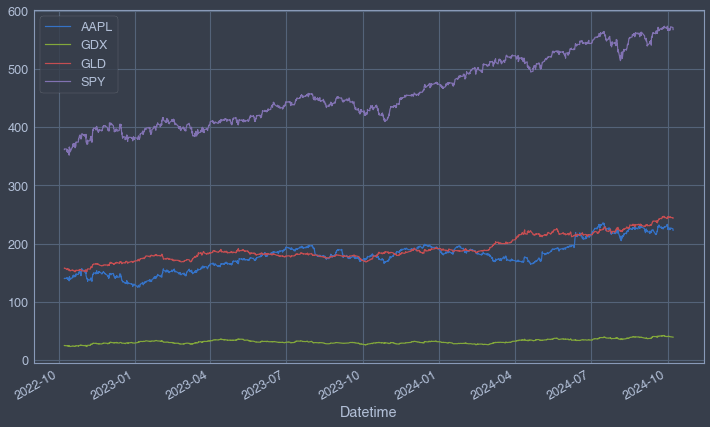

In [6]:
df = pd.read_csv('../../../data/bt/gld_gdx_aapl_spy__1H.csv', parse_dates=True, header=[0, 1], index_col=0)
df['Close'].plot()

## SMA

In [19]:
data = pd.DataFrame(df['Close']['GDX'])
data.rename(columns={'GDX': 'price'}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3492 entries, 2022-10-07 14:30:00-04:00 to 2024-10-07 14:30:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3492 non-null   float64
dtypes: float64(1)
memory usage: 40.9+ KB


<AxesSubplot:xlabel='Datetime'>

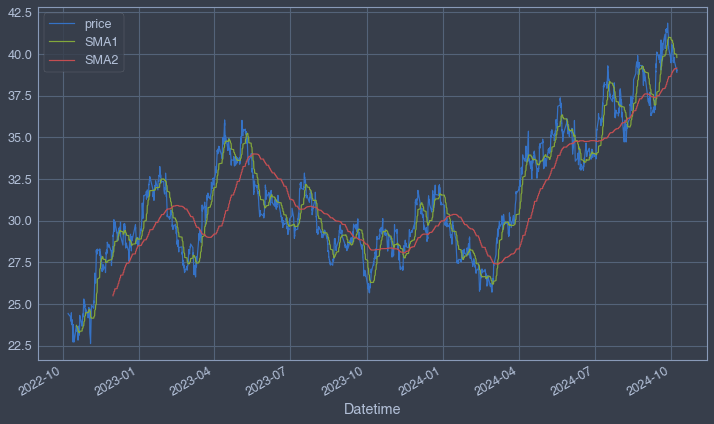

In [20]:
data['SMA1'] = data['price'].rolling(42).mean()
data['SMA2'] = data['price'].rolling(252).mean()

data.plot()

In [21]:
data.dropna(inplace=True)

In [22]:
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data['returns'] = np.log(data['price'] / data['price'].shift(1))

data['strategy'] = data['position'].shift(1) * data['returns']

In [29]:
returns = data[['strategy', 'returns']].sum().apply(np.exp)
returns.idxmin()

'strategy'

<AxesSubplot:>

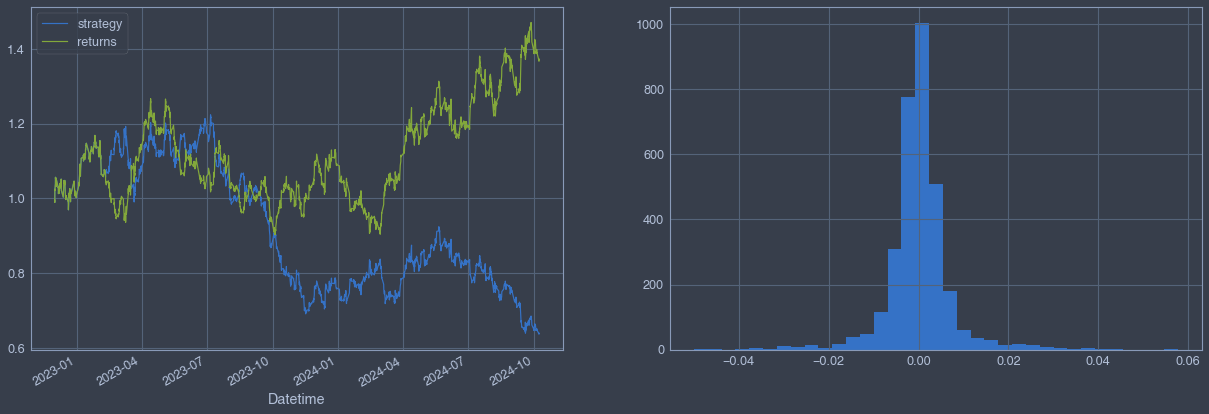

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))
data[['strategy', 'returns']].cumsum().apply(np.exp).plot(ax=ax[0])
data['returns'].hist(bins=35, ax=ax[1])

In [15]:
import os

DATA_PATH = '../../../data/bt/'

def get_backtest_data():
    bt_files = os.listdir(DATA_PATH)
    csv_files = []
    for csv in bt_files:
        try:
            tickers, period = csv.split('__')
            csv_files.append({
                'csv': csv,
                'tickers': list(map(str.upper, tickers.split('_'))),
                'period': period.replace('.csv', '')
            })
        except:
            continue
    return csv_files


In [8]:
def sma(ticker, sma1=[42], sma2=[252], d=pd.DataFrame(), visualize=False):
    d[f'{ticker}_returns'] = np.log(d[ticker] / d[ticker].shift(1))
    strategy = []
    drawdown = []
    for s1, s2 in zip(sma1, sma2):
        d[f'SMA1_{s1}'] = d[ticker].rolling(s1).mean()
        d[f'SMA2_{s2}'] = d[ticker].rolling(s2).mean()
        d.dropna(inplace=True)
        d[f'position_{s1}_{s2}'] = np.where(d[f'SMA1_{s1}'] > d[f'SMA2_{s2}'], 1, -1)
        d[f'{ticker}_strategy_{s1}_{s2}'] = d[f'position_{s1}_{s2}'].shift(1) * d[f'{ticker}_returns']
        strategy.append(f'{ticker}_strategy_{s1}_{s2}')
        
        d[f'{ticker}_cumret_{s1}_{s2}'] = d[f'{ticker}_strategy_{s1}_{s2}'].cumsum().apply(np.exp)
        d[f'{ticker}_cummax_{s1}_{s2}'] = d[f'{ticker}_cumret_{s1}_{s2}'].cummax()
        d[f'{ticker}_drawdown_{s1}_{s2}'] = d[f'{ticker}_cummax_{s1}_{s2}'] - d[f'{ticker}_cumret_{s1}_{s2}']
        drawdown.append(f'{ticker}_drawdown_{s1}_{s2}')
        
    if visualize: d[strategy+[f'{ticker}_returns']].cumsum().apply(np.exp).plot()
    
    strategy_result = d[strategy+[f'{ticker}_returns']].sum().apply(np.exp)
    drawdown_result = d[drawdown].max()
    return pd.concat([result, drwd], axis=0)
    
        

In [33]:
sma1=[42, 24, 18, 6]
sma2=[252, 180, 64, 22]
tickers = ['GLD', 'GDX', 'AAPL', 'SPY']
idx = ['SMA_'+'_'.join(map(str,ss)) for ss in zip(sma1, sma2)]\
    + ['drawdown_'+'_'.join(map(str,ss)) for ss in zip(sma1, sma2)]
pd.DataFrame(columns=tickers, index=idx)

,GLD,GDX,AAPL,SPY
SMA_42_252,NaN,NaN,NaN,NaN
SMA_24_180,NaN,NaN,NaN,NaN
SMA_18_64,NaN,NaN,NaN,NaN
SMA_6_22,NaN,NaN,NaN,NaN
drawdown_42_252,NaN,NaN,NaN,NaN
drawdown_24_180,NaN,NaN,NaN,NaN
drawdown_18_64,NaN,NaN,NaN,NaN
drawdown_6_22,NaN,NaN,NaN,NaN


In [13]:
bt_data_files = get_backtest_data()

SMA1 = {
    '15MIN': [],
    '1H': [],
    '1D': [],
}

SMA2 = {
    '15MIN': [],
    '1H': [],
    '1D': [],
}

def read_csv_bt(bt_data_file):
    file_path = f"{DATA_PATH}{bt_data_file['csv']}"
    if len(bt_data_file['tickers'])>1:
        return pd.read_csv(file_path, parse_dates=True, header=[0, 1], index_col=0)['Close']
    else:
        return pd.read_csv(file_path, parse_dates=True, index_col=0)['Close']

for bt in bt_data_files:
    csv, tickers, period = bt.values()
    data = read_csv_bt(bt)
    result_df = pd.DataFrame(columns=tickers, )
    single_ticker_result = []
    for ticker in tickers:
        single_ticker_result.append(
            sma(
                ticker,
                sma1=[42, 24, 18, 6], sma2=[252, 180, 64, 22],
                d=pd.DataFrame(data[ticker]),
        ))
    result_df = pd.concat(single_ticker_result)
result_df        

GLD_strategy_42_252     1.210578
GLD_strategy_24_180     1.001059
GLD_strategy_18_64      1.258914
GLD_strategy_6_22       0.788741
GLD_returns             1.325064
GLD_drawdown_42_252     0.102017
GLD_drawdown_24_180     0.179167
GLD_drawdown_18_64      0.142815
GLD_drawdown_6_22       0.329267
GDX_strategy_42_252     0.547866
GDX_strategy_24_180     0.695432
GDX_strategy_18_64      1.151021
GDX_strategy_6_22       0.802870
GDX_returns             1.176649
GDX_drawdown_42_252     0.587091
GDX_drawdown_24_180     0.522789
GDX_drawdown_18_64      0.557039
GDX_drawdown_6_22       0.471270
AAPL_strategy_42_252    1.141445
AAPL_strategy_24_180    1.112150
AAPL_strategy_18_64     1.049129
AAPL_strategy_6_22      0.819486
AAPL_returns            1.572987
AAPL_drawdown_42_252    0.504713
AAPL_drawdown_24_180    0.306785
AAPL_drawdown_18_64     0.283586
AAPL_drawdown_6_22      0.313121
SPY_strategy_42_252     1.205247
SPY_strategy_24_180     1.183577
SPY_strategy_18_64      1.315175
SPY_strate

## Class

In [ ]:
DATA_STORAGE = '../../../data'
class SMAVectorBacktester():
    def __init__(self, SMA1, SMA2, data_info):
#         self.symbol = symbol
#         self.start = start
#         self.end = end
#         self.interval = interval
        self.data_info = data_info
        self.data = None
        
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        
        self.results = None
        
        self.get_data()
    
    def get_data(self):
        self.data_prepare()

        self.data = self.data['Close'].to_frame()
        self.data.rename(columns={'Close': 'price'}, inplace=True)
        
        self.data['return'] = np.log(data['price'] / data['price'].shift(1))
    
    def get_data_from_yf(self):
        self.data = yf.download(
            data['symbol'],
            start=data['start'],
            end=data['end'],
            interval=data['interval'],
            
            auto_adjust=True,
            progress=False,
            show_errors=True
        )
    
    def get_data_from_csv(self):
        f = f'{DATA_STORAGE}/{self.data_info}'
        if os.path.isfile(f):
            self.data = pd.read_csv(f'{f}', index_col=0, parse_dates=True)
        
    def data_prepare(self):
        if type(self.data_info) is str and self.data_info[-3:]=='csv':
            self.get_data_from_csv()
    
    def run_strategy(self):
        data = self.data.copy().dropna()
        
        data['SMA1'] = data['price'].rolling(self.SMA1).mean()
        data['SMA2'] = data['price'].rolling(self.SMA2).mean()
        
        data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['return']
        
        data.dropna(inplace=True)
        
        data['c_returns'] = data['return'].cumsum().apply(np.exp)
        data['c_strategy'] = data['strategy'].cumsum().apply(np.exp)
        
        self.results = data
        
        # gross performance
        aperf = data['c_strategy'].iloc[-1]
        # out / underperformance
        operf = aperf - data['c_returns'].iloc[-1]
        
        return round(aperf, 2), round(operf, 2)
